# Omics integration in MEWpy

Author: Vitor Pereira and Lucas Miguel

License: [CC BY-SA 4.0](http://creativecommons.org/licenses/by-sa/4.0/)

-------

This notebook exemplifies how MEWpy integrates omics data, in this case gene expression data, into the models.
We will apply GIMME and E-Flux algorithms.

GIMME: minimizes usage of low-expression reactions while keeping the objective (e.g., biomass) above a certain value. We need a cutoff value to determine if the reaction is activated or not. It's a binary decision over the reactions.

E-Flux: uses transcriptomic data to set upper and lower bounds on metabolic fluxes. Reactions associated with more highly expressed genes will be allowed to have higher absolute flux values.

Usage in anaerobic simulations:

1. GIMME modifications for glucose uptake with gene expression data
2. GIMME modifications for xylose uptake with gene expression data

#### Packages

In addition to installing cobrapy, pandas and mewpy, we will need "matplotlib" as well.

Open a cell here and run:

pip install matplotlib

After, restart Kernell or open and close the jupyter notebook.

In [ ]:
#pip install matplotlib

In [1]:
from cobra.io import read_sbml_model
from mewpy.simulation import get_simulator
import pandas as pd


from mewpy.omics import ExpressionSet
from mewpy.omics import GIMME
from mewpy.omics import eFlux

import matplotlib.pyplot as plt

Yeast could consumes xylose (5C sugar) after a genetically modification. The XR-XDH pathway is insert, but suffers with xylitol accumulation and cofactor availability.

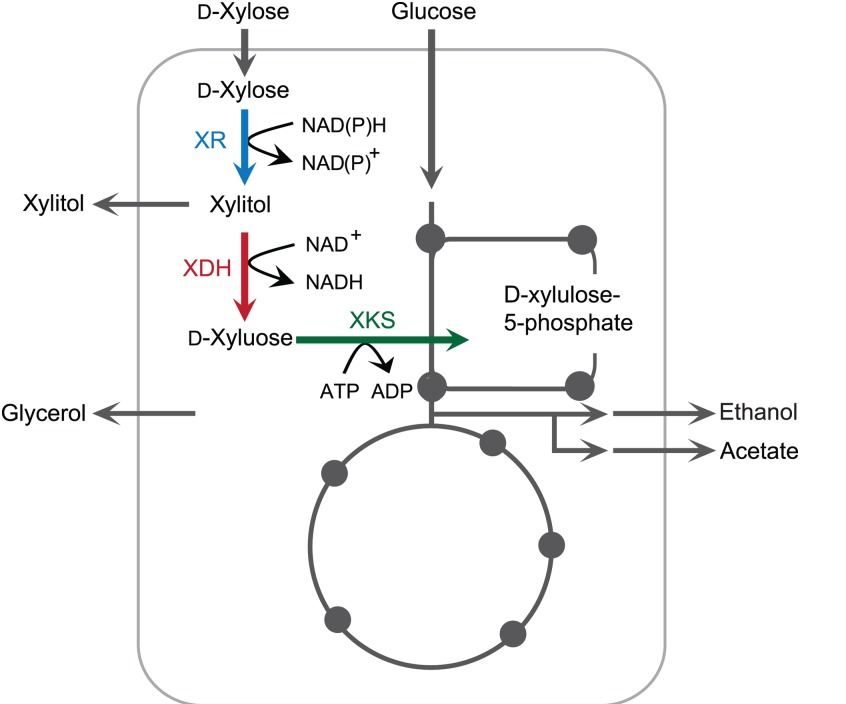

 https://europepmc.org/article/med/23183982

# 1. Default simulation


In [2]:
# Modifications to GLUCOSE anaerobic fermentation. 
# We need to block xylose and oxygen exchange reactions, and change boundaries of sterols reactions.
# Glucose starts with 10 mmol/gDW/h

model = read_sbml_model('data/iMM904.xml')

envcond = {'EX_glc__D_e':(-10,1000), "EX_xyl__D_e":(0,0), #glucose and xylose exchange
           "EX_epist_e":(-1000,1000), "EX_epistest_SC_e":(-1000,1000),"ERGSTt":(-1000,1000), 
           "EX_ergstest_SC_e":(-1000,1000), "EX_fecost_e":(-1000,1000), "EX_lanost_e":(-1000,1000),  #sterols
           "EX_lanostest_SC_e":(-1000,1000), "EX_zymst_e":(-1000,1000), "EX_zymstest_SC_e":(-1000,1000),
           "ERGTETROLter":(-1000,1000), "EX_pc_SC_e":(-1000,1000), "EX_ptd1ino_SC_e":(-1000,1000),
           "EX_o2_e":(0,0) #oxygen exchange
          }

simul = get_simulator(model, envcond = envcond)

res = simul.simulate(method="pFBA")
res

objective: 299.2640960248456
Status: OPTIMAL
Method:pFBA

In [3]:
# XR-XDH pathway
res.find(["XYLR","XYLTD_D","XYLK","RPE","EX_etoh_e"])

,Flux rate
Reaction ID,
EX_etoh_e,16.743580
RPE,-0.061768


In [4]:
# Modifications to XYLOSE anaerobic fermentation. 
# We need to block glucose and oxygen exchange reactions, and change boundaries of sterols reactions.
# Xylose starts with 10 mmol/gDW/h

envcond = {'EX_glc__D_e':(0,0), "EX_xyl__D_e":(-10,1000), #glucose and xylose exchange
           "EX_epist_e":(-1000,1000), "EX_epistest_SC_e":(-1000,1000),"ERGSTt":(-1000,1000), 
           "EX_ergstest_SC_e":(-1000,1000), "EX_fecost_e":(-1000,1000), "EX_lanost_e":(-1000,1000),  #sterols
           "EX_lanostest_SC_e":(-1000,1000), "EX_zymst_e":(-1000,1000), "EX_zymstest_SC_e":(-1000,1000),
           "ERGTETROLter":(-1000,1000), "EX_pc_SC_e":(-1000,1000), "EX_ptd1ino_SC_e":(-1000,1000),
           "EX_o2_e":(0,0) #oxygen exchange
          }

simul = get_simulator(model, envcond = envcond)

res = simul.simulate(method="pFBA")
res

objective: 310.28190418374106
Status: OPTIMAL
Method:pFBA

In [5]:
res.find(["XYLR","XYLTD_D","XYLK","RPE","EX_etoh_e"])

,Flux rate
Reaction ID,
EX_etoh_e,15.695454
RPE,-3.351755
XYLK,10.000000
XYLR,10.000000
XYLTD_D,10.000000


# 2. GIMME


In [6]:
# load expression dataset
expression = pd.read_csv("data/gene_expression_data.txt",sep="\t",index_col=0)
expression.head(5)

,Glucose_medium,Xylose_medium
genes,,
YGR121C,8.75635,12.77670
YIL009W,31.34840,18.60180
YER089C,40.99820,28.90290
YML037C,5.24355,1.31501
YDR383C,7.88679,4.49923


In [7]:
#Example with industrial transcriptomics data during glucose fermentation

envcond = {'EX_glc__D_e':(-10,1000), "EX_xyl__D_e":(0,0), #glucose and xylose exchange
           "EX_epist_e":(-1000,1000), "EX_epistest_SC_e":(-1000,1000),"ERGSTt":(-1000,1000), 
           "EX_ergstest_SC_e":(-1000,1000), "EX_fecost_e":(-1000,1000), "EX_lanost_e":(-1000,1000),  #sterols
           "EX_lanostest_SC_e":(-1000,1000), "EX_zymst_e":(-1000,1000), "EX_zymstest_SC_e":(-1000,1000),
           "ERGTETROLter":(-1000,1000), "EX_pc_SC_e":(-1000,1000), "EX_ptd1ino_SC_e":(-1000,1000),
           "EX_o2_e":(0,0) #oxygen exchange
          }

simul = get_simulator(model, envcond = envcond)

#get genes and expression data
genes = expression.index.values
conditions = ["Glucose_medium"]
exp = expression[conditions].to_numpy()

# load expression module
expr = ExpressionSet(genes, conditions, exp)

# Apply parsimonious GIMME in the model
g = GIMME(simul, expr, parsimonious= True)

# Fluxes results
g.fluxes

{'23CAPPD': 3.779729999999999, '2HMHMBQMTm': 5.097429999999999, '2HP6MPMOm': 5.097429999999999, '2HPMBQMTm': 5.097429999999999, '2HPMMBQMOm': 5.097429999999999, 'ACACT6p': 11.720428, 'ACACT7p': 11.720428, 'ACACT8p': 11.720428, 'ACACT9p': 11.720428, 'ACCOACrm': 6.629049999999999, 'AGTi': 10.81001, 'ACOAHim': 8.15859, 'ACOAO4p': 11.262046999999999, 'ACOAO5p': 11.262046999999999, 'ACOAO6p': 11.262046999999999, 'ACOAO7p': 11.262046999999999, 'ACOAO8p': 11.262046999999999, 'ACOAO9p': 11.262046999999999, 'ACOATAm': 7.145599999999999, 'ACON3MT': 0.15839999999999854, 'ACONT3m': 9.447569999999999, 'ACSm': 10.765659999999999, 'ACSp': 10.765659999999999, 'ACt2r': 9.515799999999999, 'ACtr': 11.729565, 'ADCS': 4.6807799999999995, 'ADK1m': 5.49203, 'ALDD19xr': 10.04297, 'ALDD20xm': 9.607859999999999, 'ALDD20y': 9.603919999999999, 'ALDD22x': 10.04297, 'ALDD2xm': 9.607859999999999, 'ALDD2y': 9.603919999999999, 'ADK3m': 5.49203, 'ADK4m': 5.49203, 'ADNCYC': 4.87135, 'ALLTAHr': 8.48039, 'ALLTN': 9.99551,

{'CITtcp': 0.0,
 '13BGH': 0.0,
 '13BGHe': 0.0,
 '13GS': 0.21583567770733003,
 '16GS': 0.0,
 '23CAPPD': 0.0,
 '2DDA7Ptm': 0.0,
 '2DHPtm': 0.0,
 '2DOXG6PP': 0.0,
 '2HBO': 0.0,
 '2HBt2': 0.0,
 '2HMHMBQMTm': 0.0,
 '2HP6MPMOm': 0.0,
 '2HPMBQMTm': 0.0,
 '2HPMMBQMOm': 0.0,
 '2MBACt': 0.0,
 'EX_epistest_SC_e': 0.0,
 'EX_epist_e': 0.0,
 '2MBALDt': 0.0,
 '2MBALDtm': 0.0,
 '2MBTOHt': 0.0,
 'ACACT6p': 0.0,
 '2MBTOHtm': 0.0,
 'ACACT7p': 0.0,
 '2MPPALt': 0.0,
 'ACACT8p': 0.0,
 'ACACT9p': 0.0,
 'ACALDCD': 0.0,
 'ACALDt': 0.0,
 'ACALDtm': -0.004899477491840561,
 'ACCOAC': 0.004047394449781333,
 'ACCOACrm': 0.0,
 'AGAT_SC': 0.0046978685577818875,
 'AGPRim': 0.0305646751917236,
 'AGTi': 0.0,
 'AHCYStm': 0.0,
 'ACCOAtn': 0.0,
 '2MPPALtm': 0.0,
 'ACESt': 0.0,
 'ACGAM6PS': 0.0,
 'AHCi': 0.0034235479368452068,
 'AHMMPS': 0.0,
 'AHSERL': 0.0,
 'AHSERL2': 0.010898294265623908,
 'ACGAMPM': 0.0,
 'ACGKm': 0.0305646751917236,
 '2OBUTtm': 0.036650982635003965,
 'ACGSm': 0.0,
 '2OXOADPtim': 0.05443441219583879,
 '

In [8]:
#results to dataframe
res_glu = g.dataframe
res_glu.columns = ["glu_fluxes"]
res_glu

,glu_fluxes
Reaction ID,
13GS,0.215836
ACALDtm,-0.004899
ACCOAC,0.004047
AGAT_SC,0.004698
AGPRim,0.030565
...,...
PSP_L,0.107692
PStm_SC,0.000020
URIDK2r,-0.001141


In [9]:
#pandas skill
res_glu.loc[["XYLR","XYLTD_D","XYLK","RPE","EX_etoh_e"]]

KeyError: "['XYLR', 'XYLTD_D', 'XYLK'] not in index"

In [10]:
#Example with industrial transcriptomics data during xylose fermentation

envcond = {'EX_glc__D_e':(0,0), "EX_xyl__D_e":(-10.0,1000), #glucose and xylose exchange
           "EX_epist_e":(-1000,1000), "EX_epistest_SC_e":(-1000,1000),"ERGSTt":(-1000,1000), 
           "EX_ergstest_SC_e":(-1000,1000), "EX_fecost_e":(-1000,1000), "EX_lanost_e":(-1000,1000),  #sterols
           "EX_lanostest_SC_e":(-1000,1000), "EX_zymst_e":(-1000,1000), "EX_zymstest_SC_e":(-1000,1000),
           "ERGTETROLter":(-1000,1000), "EX_pc_SC_e":(-1000,1000), "EX_ptd1ino_SC_e":(-1000,1000),
           "EX_o2_e":(0,0) #oxygen exchange
          }

simul = get_simulator(model, envcond = envcond)

#get genes and expression data
genes = expression.index.values
conditions = ["Xylose_medium"]
exp = expression[conditions].to_numpy()

# load expression module
expr = ExpressionSet(genes, conditions, exp)

# Apply parsimonious GIMME in the model
g = GIMME(simul, expr, parsimonious=True)

# Fluxes results
g.fluxes

{'23CAPPD': 2.461309999999999, '2HMHMBQMTm': 5.65515, '2HP6MPMOm': 5.65515, '2HPMBQMTm': 5.65515, '2HPMMBQMOm': 5.65515, 'ACACT6p': 10.012038, 'ACACT7p': 10.012038, 'ACACT8p': 10.012038, 'ACACT9p': 10.012038, 'ACCOAC': 0.6516099999999998, 'ACCOACrm': 8.91855, 'ACOAO4p': 9.43627, 'ACOAO5p': 9.43627, 'ACOAO6p': 9.43627, 'ACOAO7p': 9.43627, 'ACOAO8p': 9.43627, 'ACOAO9p': 9.43627, 'ACOATAm': 6.089239999999999, 'ACP1e': 2.26731, 'ACt2r': 9.47025, 'ACtr': 10.106266, 'ADCL': 5.8835299999999995, 'ADCS': 4.1363199999999996, 'ADHAPR_SC': 5.98891, 'ADK1m': 4.96474, 'ALDD20y': 9.39377, 'ALDD2y': 9.39377, 'ADK3m': 4.96474, 'ADK4m': 4.96474, 'ADNCYC': 5.831519999999999, 'ALLTAHr': 4.17078, 'ALLTN': 7.742929999999999, 'ALLTNti': 10.299094, 'ALLTTti': 3.14051, 'ALPHNH': 7.725429999999999, 'AMAOTr': 7.968439999999999, '3DH5HPBMTm': 5.65515, 'AMID': 4.45411, 'AMID2': 6.68665, 'AMID3': 6.68665, 'ATPtp_H': 1.854659999999999, 'AP4AH': 1.1367499999999993, 'BACCL': 4.2519, 'ARABR': 10.61375, 'ARGN': 7.13842,

{'CITtcp': 0.0,
 '13BGH': 0.0,
 '13BGHe': 0.0,
 '13GS': 0.06437204422850228,
 '16GS': 0.0,
 '23CAPPD': 0.0,
 '2DDA7Ptm': 0.0,
 '2DHPtm': 0.0,
 '2DOXG6PP': 0.0,
 '2HBO': 0.0,
 '2HBt2': 0.0,
 '2HMHMBQMTm': 0.0,
 '2HP6MPMOm': 0.0,
 '2HPMBQMTm': 0.0,
 '2HPMMBQMOm': 0.0,
 '2MBACt': 0.0,
 'EX_epistest_SC_e': 0.0,
 'EX_epist_e': 0.0,
 '2MBALDt': 0.0,
 '2MBALDtm': 0.0,
 '2MBTOHt': 0.0,
 'ACACT6p': 0.0,
 '2MBTOHtm': 0.0,
 'ACACT7p': 0.0,
 '2MPPALt': 0.0,
 'ACACT8p': 0.0,
 'ACACT9p': 0.0,
 'ACALDCD': 0.0,
 'ACALDt': 0.0,
 'ACALDtm': 0.0,
 'ACCOAC': 0.0012071176429172793,
 'ACCOACrm': 0.0,
 'AGAT_SC': 0.001401118692671842,
 'AGPRim': 0.009115780320338664,
 'AGTi': 0.0,
 'AHCYStm': 0.0,
 'ACCOAtn': 0.0,
 '2MPPALtm': 0.0,
 'ACESt': 0.0,
 'ACGAM6PS': 0.0,
 'AHCi': 0.0,
 'AHMMPS': 0.0,
 'AHSERL': 0.0,
 'AHSERL2': 0.003250368465186095,
 'ACGAMPM': 0.0,
 'ACGKm': 0.009115780320338664,
 '2OBUTtm': 0.01093099482096615,
 'ACGSm': 0.0,
 '2OXOADPtim': 0.01623482468998709,
 'ACHBSm': 0.01093099482096615,
 'A

In [11]:
#results to dataframe
res_xyl = g.dataframe
res_xyl.columns = ["xyl_fluxes"]
res_xyl

,xyl_fluxes
Reaction ID,
13GS,0.064372
ACCOAC,0.001207
AGAT_SC,0.001401
AGPRim,0.009116
AHSERL2,0.003250
...,...
URIDK2r,-0.000340
PTRCt3i,0.470787
PTRCtex2,0.470787


In [12]:
#pandas skill
res_xyl.loc[["XYLR","XYLTD_D","XYLK","RPE","EX_etoh_e"]]

,xyl_fluxes
Reaction ID,
XYLR,9.150000
XYLTD_D,9.150000
XYLK,9.150000
RPE,-3.066580
EX_etoh_e,14.375908


# 3. Escher maps

Lets take a look at the fluxes using Escher maps

In [13]:
import escher
from escher import Builder

In [14]:
escher.list_available_maps()

[{'organism': 'Saccharomyces cerevisiae',
  'map_name': 'iMM904.Central carbon metabolism'},
 {'organism': 'Homo sapiens',
  'map_name': 'RECON1.Inositol retinol metabolism'},
 {'organism': 'Homo sapiens', 'map_name': 'RECON1.Glycolysis TCA PPP'},
 {'organism': 'Homo sapiens', 'map_name': 'RECON1.Tryptophan metabolism'},
 {'organism': 'Homo sapiens', 'map_name': 'RECON1.Carbohydrate metabolism'},
 {'organism': 'Homo sapiens',
  'map_name': 'RECON1.Amino acid metabolism (partial)'},
 {'organism': 'Escherichia coli', 'map_name': 'iJO1366.Nucleotide metabolism'},
 {'organism': 'Escherichia coli',
  'map_name': 'iJO1366.Fatty acid biosynthesis (saturated)'},
 {'organism': 'Escherichia coli',
  'map_name': 'iJO1366.Nucleotide and histidine biosynthesis'},
 {'organism': 'Escherichia coli', 'map_name': 'e_coli_core.Core metabolism'},
 {'organism': 'Escherichia coli', 'map_name': 'iJO1366.Central metabolism'},
 {'organism': 'Escherichia coli',
  'map_name': 'iJO1366.Fatty acid beta-oxidation'}

In [15]:
# Selecting for S. cerevisiae 
builder = Builder(
    map_name='iMM904.Central carbon metabolism',
    model_name='iMM904',
)
builder

Builder()

In [16]:
#Glucose with parsimonious GIMME fluxes
builder.model = model
builder.reaction_data = res_glu

In [17]:
# Simplify the map by hiding some labels
builder.hide_secondary_metabolites = False
builder.hide_all_labels = False
builder.reaction_scale = [
    { 'type': 'min', 'color': '#000000', 'size': 12 },
    { 'type': 'median', 'color': '#ffffff', 'size': 20 },
    { 'type': 'max', 'color': '#ff0000', 'size': 25 }
]
builder.reaction_scale_preset = 'GaBuRd'

# Make all the arrows three times as thick
builder.reaction_scale = [
    {k: v * 3 if k == 'size' else v for k, v in x.items()}
    for x in builder.reaction_scale
]

#plot
builder

Builder(allow_building_duplicate_reactions=False, and_method_in_gene_reaction_rule='mean', cofactors=['atp', '…

In [18]:
#Xylose with parsimonius GIMME fluxes
builder.model = model
builder.reaction_data = res_xyl

In [19]:
# Simplify the map by hiding some labels
builder.hide_secondary_metabolites = False
builder.hide_all_labels = False
builder.reaction_scale = [
    { 'type': 'min', 'color': '#000000', 'size': 12 },
    { 'type': 'median', 'color': '#ffffff', 'size': 20 },
    { 'type': 'max', 'color': '#ff0000', 'size': 25 }
]
builder.reaction_scale_preset = 'GaBuRd'

# Make all the arrows three times as thick
builder.reaction_scale = [
    {k: v * 3 if k == 'size' else v for k, v in x.items()}
    for x in builder.reaction_scale
]

#plot
builder

Builder(allow_building_duplicate_reactions=False, and_method_in_gene_reaction_rule='mean', cofactors=['atp', '…

# 4. Comparing the results


In [20]:
# join:  join two datasets. They must have the same rownames.
final_result = res_glu.join(res_xyl)
final_result.head(10)

,glu_fluxes,xyl_fluxes
Reaction ID,,
13GS,0.215836,0.064372
ACALDtm,-0.004899,NaN
ACCOAC,0.004047,0.001207
AGAT_SC,0.004698,0.001401
AGPRim,0.030565,0.009116
AHCi,0.003424,NaN
AHSERL2,0.010898,0.003250
ACGKm,0.030565,0.009116
2OBUTtm,0.036651,0.010931


In [21]:
# create a column called "delta" with differences
final_result["delta"] = final_result["glu_fluxes"] - final_result["xyl_fluxes"]
final_result

,glu_fluxes,xyl_fluxes,delta
Reaction ID,,,
13GS,0.215836,0.064372,0.151464
ACALDtm,-0.004899,NaN,NaN
ACCOAC,0.004047,0.001207,0.002840
AGAT_SC,0.004698,0.001401,0.003297
AGPRim,0.030565,0.009116,0.021449
...,...,...,...
PSP_L,0.107692,0.030757,0.076934
PStm_SC,0.000020,0.000003,0.000017
URIDK2r,-0.001141,-0.000340,-0.000801


In [22]:
# select reactions with difference (column "delta" > 0.5)
select =[]

for index, row in final_result.iterrows():
    res = row['delta']

    if abs(res) > 0.5:
        select.append(index)
        
select

['ALCD2x_copy2',
 'CO2t',
 'CO2tm',
 'DHAK',
 'ENO',
 'ETOHt',
 'EX_etoh_e',
 'EX_h2o_e',
 'EX_h_e',
 'EX_co2_e',
 'EX_nh4_e',
 'G3PT',
 'GLUSx',
 'GAPD',
 'GLYCDy',
 'FBA',
 'GLNS',
 'H2Ot',
 'HCO3E',
 'NH4t',
 'G3PD1ir',
 'OAAt2m',
 'PFK',
 'PGK',
 'PGM',
 'PC',
 'PPA',
 'RPE',
 'RPI',
 'TKT1',
 'TKT2',
 'TPI',
 'PYK',
 'PYRDC']

In [23]:
# selecting rows for interesting reactions. Only the "delta" column.
final_result2 = final_result.loc[select]["delta"].to_frame()

# create a column called "color" based on the difference over the fluxes
final_result2['colors'] = ['red' if x < 0 else 'blue' for x in final_result2['delta']]

#sorting values by "delta" column
final_result2.sort_values('delta', inplace=True)

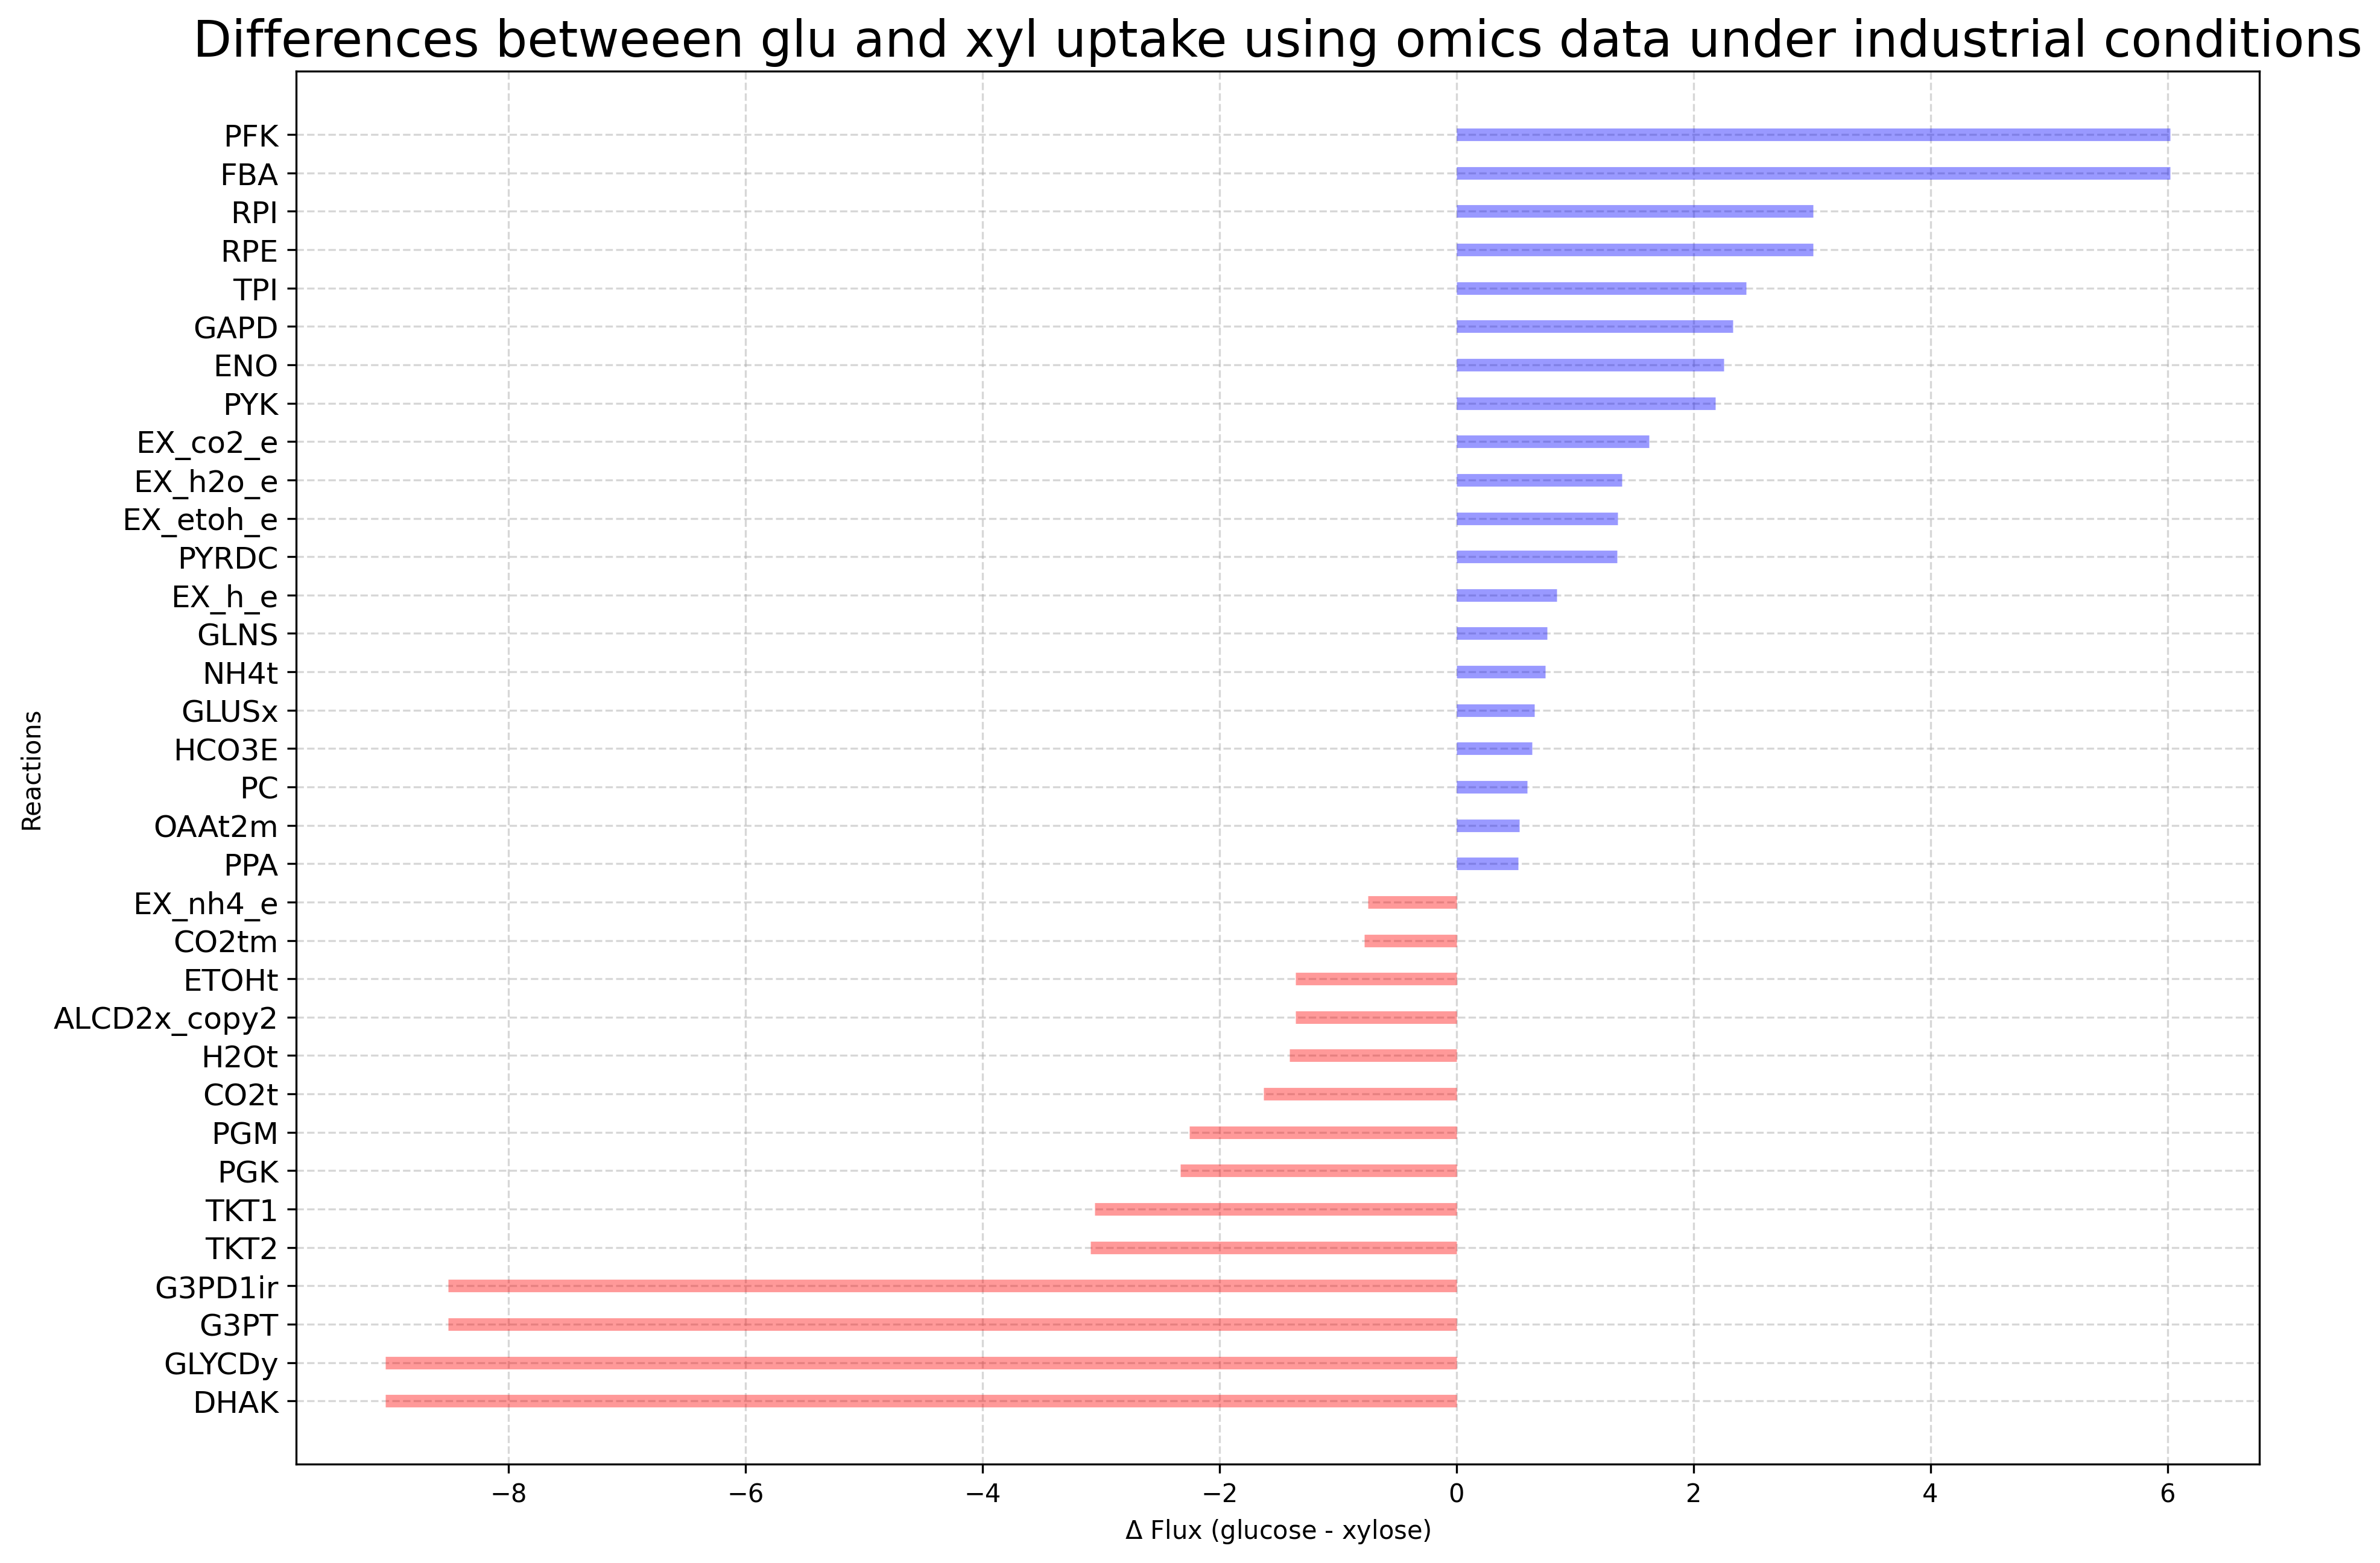

In [24]:
# Draw plot with horizontal lines (plt.hlines of matplotlib)
fig= plt.figure(figsize=(14,10), dpi= 300)
plt.hlines(y=final_result2.index, xmin=0, xmax=final_result2["delta"], color=final_result2.colors, alpha=0.4, linewidth=5)

# Decorations
plt.gca().set(ylabel='Reactions', xlabel='$\Delta$ Flux (glucose - xylose)')
plt.yticks(final_result2.index, fontsize=12)
plt.title('Differences betweeen glu and xyl uptake using omics data under industrial conditions', 
          fontdict={'size':20})
plt.grid(linestyle='--', alpha=0.5)
plt.show()

In [25]:
# Saving image
fig.savefig("GIMME_glu_xyl.png")

In [26]:
#Ethanol
final_result.loc[["EX_etoh_e"]]

,glu_fluxes,xyl_fluxes,delta
Reaction ID,,,
EX_etoh_e,15.735208,14.375908,1.3593


# Exercise

1. Load the model;
2. Create a simulation for anaerobic environment;
3. Apply E-Flux algorithm. You can substitute the method using:
    - g = eFlux(simul, expr,parsimonious=True)
4. Compare the results